In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split #pip install sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
import pyscreenshot as ImageGrab

import cv2

from tkinter import *
from PIL import Image,ImageTk

In [2]:
assert hasattr(tf, "function") # Be sure to use tensorflow 2.0

In [3]:
dataset_dir = "quick_draw_dataset"
files = [name for name in os.listdir(dataset_dir) if ".npy" in name]
max_size_per_cl = 1500
draw_class = []

# Evalueate the size of the dataset
size = 0
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    size += draws.shape[0]

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

it = 0
t = 0
for name in files:
    # Open each dataset and add the new class
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    # Add images to the buffer
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    # Iter
    it += draws.shape[0]
    t += 1

images = images.astype(np.float32)
    
# Shuffle dataset
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

images, images_valid, targets, targets_valid = train_test_split(images, targets, test_size=0.33)

print("images.shape", images.shape)
print("targets.shape", targets.shape)

print("images_valid.shape", images_valid.shape)
print("targets_valid.shape", targets_valid.shape)

print(draw_class)

images.shape (9045, 28, 28)
targets.shape (9045,)
images_valid.shape (4455, 28, 28)
targets_valid.shape (4455,)
['chapeau', 'hache', 'soleil', 'hamburger', 'avion', 'chat', 'papillon', 'serpent', 'La tour Eiffel']


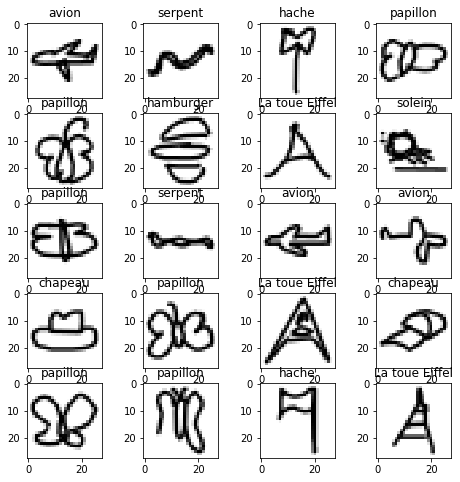

In [4]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(len(images))
    img = images[index]
    fig.add_subplot(rows, columns, i)
    plt.title(draw_class[int(targets[index])]) 
    plt.imshow(img, cmap="gray")
plt.show()

In [5]:
print("Mean and std of images", images.mean(), images.std())
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_images_valid = scaler.transform(images_valid.reshape(-1, 28*28))
print("Mean and std of scaled images", scaled_images.mean(), scaled_images.std())

scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_images_valid = scaled_images_valid.reshape(-1, 28, 28, 1)

Mean and std of images 213.29933 82.26238
Mean and std of scaled images -1.6525578e-09 0.92857146


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(scaled_images)
valid_dataset = tf.data.Dataset.from_tensor_slices(scaled_images_valid)

In [7]:
for item in train_dataset:
    print(item.shape)
    break

(28, 28, 1)


In [8]:
# Iter in the dataset with a number of epoch and batch size

epoch = 1
batch_size = 32
for batch_training in train_dataset.repeat(epoch).batch(32):
    print(batch_training.shape)
    break

(32, 28, 28, 1)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, targets))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_valid, targets_valid))

In [10]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', name="conv3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(9, activation='softmax', name="output")

    def call(self, image):
        conv1 = self.conv1(image)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        flatten = self.flatten(conv3)
        d1 = self.d1(flatten)
        output = self.out(d1)
        return output

model = ConvModel()
model.predict(scaled_images[0:1])

array([[0.11570887, 0.10961387, 0.12517776, 0.10347775, 0.11121061,
        0.09659807, 0.12036902, 0.11567852, 0.10216551]], dtype=float32)

In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [12]:
# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [13]:
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(image)
        # Get the error/loss on these predictions
        loss = loss_object(targets, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(targets, predictions)

In [14]:
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_object(targets, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

In [15]:
fenTrain = Tk()
 
def train() :
    global b
    epoch = 2
    batch_size = 32
    b = 0
    for epoch in range(epoch):
         #Training set
        for images_batch, targets_batch in train_dataset.batch(batch_size):
            train_step(images_batch, targets_batch)
            template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
            print(template.format(
                b, len(targets), train_loss.result(), 
                train_accuracy.result()*100
            ), end="")
            b += batch_size
        # Validation set
        for images_batch, targets_batch in valid_dataset.batch(batch_size):
            valid_step(images_batch, targets_batch)

        template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
        print(template.format(
            epoch+1,
            valid_loss.result(), 
            valid_accuracy.result()*100)
        )
        valid_loss.reset_states()
        valid_accuracy.reset_states()
        train_accuracy.reset_states()
        train_loss.reset_states()
    fenTrain.destroy()   

labelTrain = Label(fenTrain,text="Appuyer ci-dessous pour lancer l'entraînement du modèle.\n Ce processus peut prendre quelques minutes...")
labelTrain.grid(row=0,column=0)

bou1=Button(fenTrain,text="Entraîner le modèle",command=train)
bou1.grid(row=1,column=0,pady=50,padx=75)

fenTrain.geometry("385x200")

fenTrain.mainloop()

 Batch 9024/9045, Loss: 0.5840625762939453, Accuracy: 82.664451599121126
Epoch 1, Valid Loss: 0.3695875108242035, Valid Accuracy: 89.31537628173828
 Batch 18080/9045, Loss: 0.24086712300777435, Accuracy: 92.83582305908203
Epoch 2, Valid Loss: 0.46239617466926575, Valid Accuracy: 87.63187408447266


[[7.2990498e-04 1.5883859e-02 1.2907218e-03 4.9800789e-03 9.5096117e-01
  4.3236637e-03 8.6000869e-03 9.7463600e-04 1.2255877e-02]]
(1, 28, 28, 1)


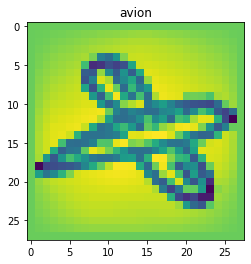

In [16]:
print(model.predict(scaled_images[0:1]))
print(scaled_images[0:1].shape)

plt.imshow(scaled_images[0].reshape(28,28))
plt.title(draw_class[np.int(targets[0])])
plt.show()

In [17]:
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.figure import Figure

import tkinter.ttk as ttk
from tkinter import font
def fen_test():
    
    class main:
        
        def __init__(self,master):
            
            self.master = master
            self.color_fg = 'black'
            self.color_bg = 'white'
            self.old_x = None
            self.old_y = None
            self.penwidth = 10
            self.drawWidgets()
            self.c.bind('<B1-Motion>',self.paint)
            self.c.bind('<ButtonRelease-1>',self.reset)

        def paint(self,e):
            
            if self.old_x and self.old_y:
                #self.c.create_line(self.old_x,self.old_y,e.x,e.y,width=self.penwidth,fill=self.color_fg,capstyle=ROUND,smooth=False)
                self.c.create_rectangle(self.old_x-5, self.old_y-5, self.old_x+5, self.old_y+5,width=10)
                
            self.old_x = e.x
            self.old_y = e.y

        def reset(self,e):
            
            self.old_x = None
            self.old_y = None      

        def save(self):
            
            capture = ImageGrab.grab()
            x = self.master.winfo_rootx() + self.c.winfo_x()
            y = self.master.winfo_rooty() + self.c.winfo_y()
            x1 = x + self.c.winfo_width()
            y1 = y + self.c.winfo_height()

            with open('nombres.txt', 'r') as f:
                read = f.read().strip()
                read = ''.join(i for i in read if i.isdigit())
            with open('nombres.txt', 'w') as f: f.write(str(int(read) + 1))


            capture.crop((x + 1,y + 1,x1 - 1,y1 - 1)).save("./draw_test/" + read + ".png")
            self.master.destroy()
            
            fen_resultats()
            
        def clear(self):
            
            self.c.delete(ALL)

        def drawWidgets(self):

            self.c = Canvas(self.master,width=280,height=280,bg=self.color_bg,)
            self.c.pack(fill=NONE,expand=False)
            self.c.place(relx=0.5, rely=0.5, anchor=CENTER)
            

            menu = Menu(self.master)
            self.master.config(menu=menu)
            filemenu = Menu(menu)
            menu.add_command(label='Teste',command=self.save)
            optionmenu = Menu(menu)
            menu.add_command(label='Effacer',command=self.clear)



    if __name__ == '__main__':
        root = Tk()
        main(root)
        root.attributes("-fullscreen", 1)
        root.title('Dessine ton image !')
        Label(root, text="\n\nVoici les différentes images que vous pouvez dessiner : \n").pack()
        Label(root, text="Un avion  | Une banane | Un papillon ").pack()
        Label(root, text="Une tête de chat  | Des tongue | Un hamburger ").pack()
        Label(root, text="Un chapeau  | Un serpent | Le soleil ").pack()
        Label(root, text="\n Attention à dessiner votre image le plus grand possible pour plus d'efficacité !").pack()
        root.mainloop()


    
def fen_resultats() :
    
    with open('nombres.txt', 'r') as f:
        read = f.read().strip()
        read = str(int(''.join(i for i in read if i.isdigit())) - 1)
        image = cv2.imread("./draw_test/" + read + ".png", 0)
    print(image[140])
    image = cv2.resize(image, (28, 28), interpolation=cv2.INTER_AREA)
    image = image.astype(np.float32)
    print(image.shape)
    img_norm = scaler.transform(image.reshape(-1, 28*28))
    print(img_norm.shape)

    img_norm = img_norm.reshape(-1, 28, 28, 1)
    print(img_norm.shape)
    probas = model.predict(img_norm)
    probas = np.round(probas,4)

    probas_targets = []
    for i in range(len(probas[0])) :
        t = []
        t.append(draw_class[i])
        t.append(probas[0][i])
        probas_targets.append(t)

    for i in range(len(probas_targets)) :
        probas_targets[i][1] = probas_targets[i][1].item()
        probas_targets[i][1] *= 100
        probas_targets[i][1] = round(probas_targets[i][1],3)

    probas_targets = sorted(probas_targets, key=lambda val: val[1], reverse=True)

    display_probas = ""
    for i in range(len(probas_targets)):
        display_probas += str(i+1) + "." + probas_targets[i][0] + " : à " + str(probas_targets[i][1]) + "%\n\n"

    fen1 = Toplevel(fenMenu)
    fen1.title("Résultats")
    fen1.attributes("-fullscreen", 1)
    
    with open('nombres.txt', 'r') as f:
        read = f.read().strip()
        read = str(int(''.join(i for i in read if i.isdigit())) - 1)
        image = Image.open("./draw_test/" + read + ".png") 
    
    image = image.resize((750,750))
    photo = ImageTk.PhotoImage(image) 
 
    canvas = Canvas(fen1, width = 800, height = 800) 
    canvas.create_image(400,400, image=photo)
    canvas.grid(column=0,row=0,rowspan=4,columnspan=4)

    label1 = Label(fen1,text="Vous avez dessiné : ")
    label1.grid(column=4,row=1)

    results=Label(fen1,text= display_probas)
    results.grid(column=4,row=2, columnspan=2)

    exitButton = Button(fen1,text="Quitter",command=fen1.destroy)
    exitButton.grid(column=1,row=4,columnspan=2)

    
    
    
    
    fig = Figure(figsize=(8, 6), dpi=100)
   
    
    x = [i for i in range(1, 10)]
    xnom = [probas_targets[i][0] for i in range(len(probas_targets))]
    
    print(x)
    print(xnom)
    nomx = []
    #for i in range(len(probas_targets)):
    #    fig.add_subplot(111).plot([i, i], [probas_targets[i][1], 0], linewidth=6)
    #    plt.show()
    
    
    graph = fig.add_subplot(111)
    graph.bar(x, [probas_targets[i][1] for i in range(len(probas_targets))])
    graph.set_xticks(x)
    graph.set_xticklabels(xnom, rotation = 45)
    graph.tick_params(axis='both', which='major', labelsize=10)
    
    canvas = FigureCanvasTkAgg(fig, master=fen1)  # A tk.DrawingArea.
    canvas.draw()
    canvas.get_tk_widget().grid(column = 6, row = 2)
    
        
    fen1.mainloop()

    
    
    
    
fenMenu = Tk()
fenMenu.attributes("-fullscreen", 1)

testButton = Button(fenMenu,text="Cliquez pour tester votre propre image",command=fen_test)

testButton.place(relx=0.5, rely=0.5, anchor=CENTER)
testButton.config(background="white", bd=3, justify=CENTER, height=300, width=800)

fenMenu.mainloop()


HOLAAAAAA [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 255 255 255 255 255 255 255 255 